In [ ]:
import time
import os

import gym
import pybullet_envs

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_

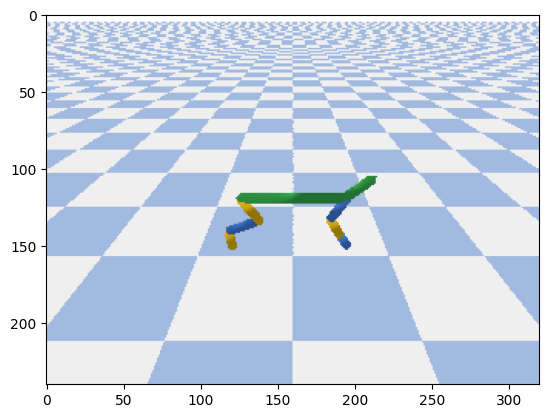

In [ ]:
env = gym.make('HalfCheetahBulletEnv-v0')
env.reset()
image = env.render(mode='rgb_array')
plt.imshow(image)
plt.show()
env.close()

In [ ]:
class GymWrapper_PyBullet(object):

    metadata = {'render.modes': ['human', 'rgb_array']}
    reward_range = (-np.inf, np.inf)


    def __init__(self, env, cam_dist=3, cam_yaw=0, cam_pitch=-30, render_width=320, render_height=240):
        self._env = env
        self._env.env._cam_dist = cam_dist
        self._env.env._cam_yaw = cam_yaw
        self._env.env._cam_pitch = cam_pitch
        self._env.env._render_width = render_width
        self._env.env._render_height = render_height

    def __getattr(self, name):
        return getattr(self._env, name)

    @property
    def observation_space(self):
        width = self._env.env._render_width
        height = self._env.env._render_height
        return gym.spaces.Box(0, 255, (height, width, 3), dtype=np.uint8)

    @property
    def action_space(self):
        return self._env.action_space


    def step(self, action):
        _, reward, done, info = self._env.step(action)
        obs = self._env.render(mode="rgb_array")
        return obs, reward, done, info

    def reset(self):
        self._env.reset()
        obs = self._env.render(mode="rgb_array")
        return obs

    def render(self, mode='human', **kwargs):
        return self._env.render(mode, **kwargs)

    def close(self):
        self._env.close()

In [ ]:
class RepeatAction(gym.Wrapper):

    def __init__(self, env, skip=4):
        gym.Wrapper.__init__(self, env)
        self._skip = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        total_reward = 0.0
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

In [ ]:
def make_env():
    env = gym.make('HalfCheetahBulletEnv-v0')
    env = GymWrapper_PyBullet(env, cam_dist=2, cam_pitch=0, render_width=64, render_height=64)
    env = RepeatAction(env, skip=2)
    return env

In [ ]:
class ReplayBuffer(object):

    def __init__(self, capacity, observation_shape, action_dim):
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.uint8)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=np.bool)

        self.index = 0
        self.is_filled = False

    def push(self, observation, action, reward, done):

        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done


        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size, chunk_length):

        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(initial_index <= episode_borders,
                                              episode_borders < final_index).any()
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:])
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1])
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        sampled_done = self.done[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_done

    def __len__(self):
        return self.capacity if self.is_filled else self.index

In [ ]:
def preprocess_obs(obs):

    obs = obs.astype(np.float32)
    normalized_obs = obs / 255.0 - 0.5
    return normalized_obs

In [ ]:
def lambda_target(rewards, values, gamma, lambda_):

    V_lambda = torch.zeros_like(rewards, device=rewards.device)

    H = rewards.shape[0] - 1
    V_n = torch.zeros_like(rewards, device=rewards.device)
    V_n[H] = values[H]
    for n in range(1, H+1):

        V_n[:-n] = (gamma ** n) * values[n:]
        for k in range(1, n+1):
            if k == n:
                V_n[:-n] += (gamma ** (n-1)) * rewards[k:]
            else:
                V_n[:-n] += (gamma ** (k-1)) * rewards[k:-n+k]


        if n == H:
            V_lambda += (lambda_ ** (H-1)) * V_n
        else:
            V_lambda += (1 - lambda_) * (lambda_ ** (n-1)) * V_n

    return V_lambda

In [ ]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False,
    )


def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=1, stride=stride, bias=False
    )

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, channels, stride=1):
        super().__init__()
        self.conv1 = conv1x1(in_channels, channels)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = conv3x3(channels, channels, stride)
        self.bn2 = nn.BatchNorm2d(channels)
        self.conv3 = conv1x1(channels, channels * self.expansion)
        self.bn3 = nn.BatchNorm2d(channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        if in_channels != channels * self.expansion:
            self.shortcut = nn.Sequential(
                conv1x1(in_channels, channels * self.expansion, stride),
                nn.BatchNorm2d(channels * self.expansion),
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)

        out = self.relu(out)

        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self, block, layers):
        super().__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = self._make_layer(block, 64, layers[0], stride=1)
        self.conv3 = self._make_layer(block, 128, layers[1], stride=2)
        self.conv4 = self._make_layer(block, 256, layers[2], stride=2)
        self.conv5 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, channels, blocks, stride):
        layers = []

        layers.append(block(self.in_channels, channels, stride))

        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)

    def forward(self, obs):
        hidden = self.conv1(obs)
        hidden = self.bn1(hidden)
        hidden = self.relu(hidden)
        hidden = self.maxpool(hidden)

        hidden = self.conv2(hidden)
        hidden = self.conv3(hidden)
        hidden = self.conv4(hidden)
        hidden = self.conv5(hidden)

        hidden = self.avgpool(hidden)
        embedded_obs = torch.flatten(hidden, 1)
        return embedded_obs

In [ ]:
class RecurrentStateSpaceModel(nn.Module):

    def __init__(self, state_dim, action_dim, rnn_hidden_dim,
                 hidden_dim=200, min_stddev=0.1, act=F.elu):
        super(RecurrentStateSpaceModel, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.rnn_hidden_dim = rnn_hidden_dim
        self.fc_state_action = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc_rnn_hidden = nn.Linear(rnn_hidden_dim, hidden_dim)
        self.fc_state_mean_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_prior = nn.Linear(hidden_dim, state_dim)
        self.fc_rnn_hidden_embedded_obs = nn.Linear(rnn_hidden_dim + 2048, hidden_dim)
        self.fc_state_mean_posterior = nn.Linear(hidden_dim, state_dim)
        self.fc_state_stddev_posterior = nn.Linear(hidden_dim, state_dim)
        self.rnn = nn.GRUCell(hidden_dim, rnn_hidden_dim)
        self._min_stddev = min_stddev
        self.act = act

    def forward(self, state, action, rnn_hidden, embedded_next_obs):

        next_state_prior, rnn_hidden = self.prior(state, action, rnn_hidden)
        next_state_posterior = self.posterior(rnn_hidden, embedded_next_obs)
        return next_state_prior, next_state_posterior, rnn_hidden

    def prior(self, state, action, rnn_hidden):

        hidden = self.act(self.fc_state_action(torch.cat([state, action], dim=1)))
        rnn_hidden = self.rnn(hidden, rnn_hidden)
        hidden = self.act(self.fc_rnn_hidden(rnn_hidden))

        mean = self.fc_state_mean_prior(hidden)
        stddev = F.softplus(self.fc_state_stddev_prior(hidden)) + self._min_stddev
        return Normal(mean, stddev), rnn_hidden

    def posterior(self, rnn_hidden, embedded_obs):

        hidden = self.act(self.fc_rnn_hidden_embedded_obs(
            torch.cat([rnn_hidden, embedded_obs], dim=1)))
        mean = self.fc_state_mean_posterior(hidden)
        stddev = F.softplus(self.fc_state_stddev_posterior(hidden)) + self._min_stddev
        return Normal(mean, stddev)

In [ ]:
class ObservationModel(nn.Module):

    def __init__(self, state_dim, rnn_hidden_dim):
        super(ObservationModel, self).__init__()
        self.fc = nn.Linear(state_dim + rnn_hidden_dim, 2048)
        self.dc1 = nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2)
        self.dc2 = nn.ConvTranspose2d(1024, 128, kernel_size=3, stride=2)
        self.dc3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        self.dc4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2)
        self.dc5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2)

    def forward(self, state, rnn_hidden):
        hidden = self.fc(torch.cat([state, rnn_hidden], dim=1))
        hidden = hidden.view(hidden.size(0), 2048, 1, 1)
        hidden = F.relu(self.dc1(hidden))
        hidden = F.relu(self.dc2(hidden))
        hidden = F.relu(self.dc3(hidden))
        hidden = F.relu(self.dc4(hidden))
        obs = self.dc5(hidden)
        return obs

In [ ]:
class RewardModel(nn.Module):

    def __init__(self, state_dim, rnn_hidden_dim, hidden_dim=400, act=F.elu):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state, rnn_hidden):
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        reward = self.fc4(hidden)
        return reward

In [ ]:
class ValueModel(nn.Module):

    def __init__(self, state_dim, rnn_hidden_dim, hidden_dim=400, act=F.elu):
        super(ValueModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.act = act

    def forward(self, state, rnn_hidden):
        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        state_value = self.fc4(hidden)
        return state_value

In [ ]:
class ActionModel(nn.Module):

    def __init__(self, state_dim, rnn_hidden_dim, action_dim,
                 hidden_dim=400, act=F.elu, min_stddev=1e-4, init_stddev=5.0):
        super(ActionModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + rnn_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_stddev = nn.Linear(hidden_dim, action_dim)
        self.act = act
        self.min_stddev = min_stddev
        self.init_stddev = np.log(np.exp(init_stddev) - 1)

    def forward(self, state, rnn_hidden, training=True):

        hidden = self.act(self.fc1(torch.cat([state, rnn_hidden], dim=1)))
        hidden = self.act(self.fc2(hidden))
        hidden = self.act(self.fc3(hidden))
        hidden = self.act(self.fc4(hidden))

        mean = self.fc_mean(hidden)
        mean = 5.0 * torch.tanh(mean / 5.0)
        stddev = self.fc_stddev(hidden)
        stddev = F.softplus(stddev + self.init_stddev) + self.min_stddev

        if training:
            action = torch.tanh(Normal(mean, stddev).rsample())
        else:
            action = torch.tanh(mean)
        return action

In [ ]:
class Agent:

    def __init__(self, encoder, rssm, action_model):
        self.encoder = encoder
        self.rssm = rssm
        self.action_model = action_model

        self.device = next(self.action_model.parameters()).device
        self.rnn_hidden = torch.zeros(1, rssm.rnn_hidden_dim, device=self.device)

    def __call__(self, obs, training=True):
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        obs = obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)

        with torch.no_grad():
            embedded_obs = self.encoder(obs)
            state_posterior = self.rssm.posterior(self.rnn_hidden, embedded_obs)
            state = state_posterior.sample()
            action = self.action_model(state, self.rnn_hidden, training=training)

            _, self.rnn_hidden = self.rssm.prior(state, action, self.rnn_hidden)

        return action.squeeze().cpu().numpy()

    def reset(self):
        self.rnn_hidden = torch.zeros(1, self.rssm.rnn_hidden_dim, device=self.device)

In [ ]:
buffer_capacity =20000
replay_buffer = ReplayBuffer(capacity=buffer_capacity,
                              observation_shape=env.observation_space.shape,
                              action_dim=env.action_space.shape[0])


state_dim = 30
rnn_hidden_dim = 200
encoder = Encoder(Bottleneck, [3, 4, 6, 3]).to(device)
rssm = RecurrentStateSpaceModel(state_dim,
                                   env.action_space.shape[0],
                                   rnn_hidden_dim).to(device)
obs_model = ObservationModel(state_dim, rnn_hidden_dim).to(device)
reward_model = RewardModel(state_dim, rnn_hidden_dim).to(device)

value_model = ValueModel(state_dim, rnn_hidden_dim).to(device)
action_model = ActionModel(state_dim, rnn_hidden_dim,
                             env.action_space.shape[0]).to(device)


model_lr = 6e-4
value_lr = 8e-5
action_lr = 8e-5
eps = 1e-4
model_params = (list(encoder.parameters()) +
                  list(rssm.parameters()) +
                  list(obs_model.parameters()) +
                  list(reward_model.parameters()))
model_optimizer = torch.optim.Adam(model_params, lr=model_lr, eps=eps)
value_optimizer = torch.optim.Adam(value_model.parameters(), lr=value_lr, eps=eps)
action_optimizer = torch.optim.Adam(action_model.parameters(), lr=action_lr, eps=eps)


seed_episodes = 5
all_episodes = 300
test_interval = 10
model_save_interval = 20
collect_interval = 100

action_noise_var = 0.3

batch_size = 50
chunk_length = 50
imagination_horizon = 15


gamma = 0.99
lambda_ = 0.95
clip_grad_norm = 100
free_nats = 3

In [ ]:
env = make_env()
for episode in range(seed_episodes):
    obs = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_obs, reward, done, _ = env.step(action)
        replay_buffer.push(obs, action, reward, done)
        obs = next_obs

In [ ]:
for episode in range(seed_episodes, all_episodes):

    start = time.time()

    policy = Agent(encoder, rssm, action_model)

    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = policy(obs)
        action += np.random.normal(0, np.sqrt(action_noise_var),
                                     env.action_space.shape[0])
        next_obs, reward, done, _ = env.step(action)
        replay_buffer.push(obs, action, reward, done)
        obs = next_obs
        total_reward += reward

    writer.add_scalar('total reward at train', total_reward, episode)
    print('episode [%4d/%4d] is collected. Total reward is %f' %
            (episode+1, all_episodes, total_reward))
    print('elasped time for interaction: %.2fs' % (time.time() - start))

    start = time.time()
    for update_step in range(collect_interval):
        observations, actions, rewards, _ = \
            replay_buffer.sample(batch_size, chunk_length)

        observations = preprocess_obs(observations)
        observations = torch.as_tensor(observations, device=device)
        observations = observations.transpose(3, 4).transpose(2, 3)
        observations = observations.transpose(0, 1)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1)

        embedded_observations = encoder(
            observations.reshape(-1, 3, 64, 64)).view(chunk_length, batch_size, -1)

        states = torch.zeros(chunk_length, batch_size, state_dim, device=device)
        rnn_hiddens = torch.zeros(chunk_length, batch_size, rnn_hidden_dim, device=device)

        state = torch.zeros(batch_size, state_dim, device=device)
        rnn_hidden = torch.zeros(batch_size, rnn_hidden_dim, device=device)

        kl_loss = 0
        for l in range(chunk_length-1):
            next_state_prior, next_state_posterior, rnn_hidden = \
                rssm(state, actions[l], rnn_hidden, embedded_observations[l+1])
            state = next_state_posterior.rsample()
            states[l+1] = state
            rnn_hiddens[l+1] = rnn_hidden
            kl = kl_divergence(next_state_prior, next_state_posterior).sum(dim=1)
            kl_loss += kl.clamp(min=free_nats).mean()
        kl_loss /= (chunk_length - 1)

        states = states[1:]
        rnn_hiddens = rnn_hiddens[1:]

        flatten_states = states.view(-1, state_dim)
        flatten_rnn_hiddens = rnn_hiddens.view(-1, rnn_hidden_dim)
        recon_observations = obs_model(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 3, 64, 64)
        predicted_rewards = reward_model(flatten_states, flatten_rnn_hiddens).view(chunk_length-1, batch_size, 1)

        obs_loss = 0.5 * F.mse_loss(recon_observations, observations[1:], reduction='none').mean([0, 1]).sum()
        reward_loss = 0.5 * F.mse_loss(predicted_rewards, rewards[:-1])

        model_loss = kl_loss + obs_loss + reward_loss
        model_optimizer.zero_grad()
        model_loss.backward()
        clip_grad_norm_(model_params, clip_grad_norm)
        model_optimizer.step()

        flatten_states = flatten_states.detach()
        flatten_rnn_hiddens = flatten_rnn_hiddens.detach()

        imaginated_states = torch.zeros(imagination_horizon + 1,
                                         *flatten_states.shape,
                                          device=flatten_states.device)
        imaginated_rnn_hiddens = torch.zeros(imagination_horizon + 1,
                                                *flatten_rnn_hiddens.shape,
                                                device=flatten_rnn_hiddens.device)

        imaginated_states[0] = flatten_states
        imaginated_rnn_hiddens[0] = flatten_rnn_hiddens

        for h in range(1, imagination_horizon + 1):
            actions = action_model(flatten_states, flatten_rnn_hiddens)
            flatten_states_prior, flatten_rnn_hiddens = rssm.prior(flatten_states,
                                                                   actions,
                                                                   flatten_rnn_hiddens)
            flatten_states = flatten_states_prior.rsample()
            imaginated_states[h] = flatten_states
            imaginated_rnn_hiddens[h] = flatten_rnn_hiddens

        flatten_imaginated_states = imaginated_states.view(-1, state_dim)
        flatten_imaginated_rnn_hiddens = imaginated_rnn_hiddens.view(-1, rnn_hidden_dim)
        imaginated_rewards = \
            reward_model(flatten_imaginated_states,
                        flatten_imaginated_rnn_hiddens).view(imagination_horizon + 1, -1)
        imaginated_values = \
            value_model(flatten_imaginated_states,
                        flatten_imaginated_rnn_hiddens).view(imagination_horizon + 1, -1)
        lambda_target_values = lambda_target(imaginated_rewards, imaginated_values, gamma, lambda_)

        action_loss = -1 * (lambda_target_values.mean())
        action_optimizer.zero_grad()
        action_loss.backward()
        clip_grad_norm_(action_model.parameters(), clip_grad_norm)
        action_optimizer.step()

        imaginated_values = \
            value_model(flatten_imaginated_states.detach(),
                        flatten_imaginated_rnn_hiddens.detach()).view(imagination_horizon + 1, -1)
        lambda_target_values = lambda_target(imaginated_rewards.detach(), imaginated_values, gamma, lambda_)

        value_loss = 0.5 * F.mse_loss(imaginated_values, lambda_target_values.detach())
        value_optimizer.zero_grad()
        value_loss.backward()
        clip_grad_norm_(value_model.parameters(), clip_grad_norm)
        value_optimizer.step()


        print('update_step: %3d model loss: %.5f, kl_loss: %.5f, '
             'obs_loss: %.5f, reward_loss: %.5f, '
             'value_loss: %.5f action_loss: %.5f'
                % (update_step + 1, model_loss.item(), kl_loss.item(),
                    obs_loss.item(), reward_loss.item(),
                    value_loss.item(), action_loss.item()))
        total_update_step = episode * collect_interval + update_step
        writer.add_scalar('model loss', model_loss.item(), total_update_step)
        writer.add_scalar('kl loss', kl_loss.item(), total_update_step)
        writer.add_scalar('obs loss', obs_loss.item(), total_update_step)
        writer.add_scalar('reward loss', reward_loss.item(), total_update_step)
        writer.add_scalar('value loss', value_loss.item(), total_update_step)
        writer.add_scalar('action loss', action_loss.item(), total_update_step)

    print('elasped time for update: %.2fs' % (time.time() - start))

    if (episode + 1) % test_interval == 0:
        policy = Agent(encoder, rssm, action_model)
        start = time.time()
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = policy(obs, training=False)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

        writer.add_scalar('total reward at test', total_reward, episode)
        print('Total test reward at episode [%4d/%4d] is %f' %
                (episode+1, all_episodes, total_reward))
        print('elasped time for test: %.2fs' % (time.time() - start))

    if (episode + 1) % model_save_interval == 0:
        model_log_dir = os.path.join(log_dir, 'episode_%04d' % (episode + 1))
        os.makedirs(model_log_dir)
        torch.save(encoder.state_dict(), os.path.join(model_log_dir, 'encoder.pth'))
        torch.save(rssm.state_dict(), os.path.join(model_log_dir, 'rssm.pth'))
        torch.save(obs_model.state_dict(), os.path.join(model_log_dir, 'obs_model.pth'))
        torch.save(reward_model.state_dict(), os.path.join(model_log_dir, 'reward_model.pth'))
        torch.save(value_model.state_dict(), os.path.join(model_log_dir, 'value_model.pth'))
        torch.save(action_model.state_dict(), os.path.join(model_log_dir, 'action_model.pth'))

writer.close()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [ ]:
def display_video(frames):
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()

In [ ]:
policy = Agent(encoder, rssm, action_model)
obs = env.reset()
done = False
total_reward = 0
frames = [obs]
while not done:
    action = policy(obs, training=False)
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    frames.append(obs)

print('Total Reward:', total_reward)

In [ ]:
display_video(frames)

In [ ]:
policy = Agent(encoder, rssm, action_model)
obs = env.reset()
for _ in range(np.random.randint(5, 100)):
    action = policy(obs, training=False)
    obs, _, _, _ = env.step(action)

preprocessed_obs = preprocess_obs(obs)
preprocessed_obs = torch.as_tensor(preprocessed_obs, device=device)
preprocessed_obs = preprocessed_obs.transpose(1, 2).transpose(0, 1).unsqueeze(0)
with torch.no_grad():
    embedded_obs = encoder(preprocessed_obs)

rnn_hidden = policy.rnn_hidden
state = rssm.posterior(rnn_hidden, embedded_obs).sample()
frame = np.zeros((64, 128, 3))
frames = []

prediction_length = 100
for _ in range(prediction_length):
    action = policy(obs)
    obs, _, _, _ = env.step(action)

    action = torch.as_tensor(action, device=device).unsqueeze(0)
    with torch.no_grad():
        state_prior, rnn_hidden = rssm.prior(state, action, rnn_hidden)
        state = state_prior.sample()
        predicted_obs = obs_model(state, rnn_hidden)

    frame[:, :64, :] = preprocess_obs(obs)
    frame[:, 64:, :] = predicted_obs.squeeze().transpose(0, 1).transpose(1, 2).cpu().numpy()
    frames.append((frame + 0.5).clip(0.0, 1.0))

In [ ]:
display_video(frames)